# 06 - Doc2Vec
This notebook explores the governance data set using Doc2Vec. Doc2vec might be a good fit for our project as dimensionality reducer.

This code is largely based on [Document-Clustering-Doc2vec](https://github.com/aniketbote/Document-Clustering-Doc2vec/blob/master/Clustering/Clustering_code_Doc2Vec/clustering_Documents_Doc2Vec.py) by [Aniket Bote](https://github.com/aniketbote). We did remove the fixed seed for the randomizer.

Further reading [A gentle introduction to Doc2Vec](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e) by [Gidi Shperber](https://medium.com/@gidishperber) or [Doc2Vec — Computing Similarity between Documents](https://medium.com/red-buffer/doc2vec-computing-similarity-between-the-documents-47daf6c828cd) by [Abdul Hafeez Fahad](https://medium.com/@a.h.fahad18).


** Kaartje met clusters over gemeenten, dus voor zowel LSA and Doc2Vec een kaartje genereren welke gemeenten in welk cluster zitten
XXX **

---
## Dependencies and Imports
This section deals with fulfilling depenencies and installing the right packages for use in the code below.

Something to keep in mind is that a lot of sample code out there uses Gensum version 3, where we use the current-as-of-this-writing Gensim version 4. The API has changed quite a bit between versions 3 and 4 and sample code may need to be refactored to use the new API before it works. Most changes are in the naming and will cause run-time errors, so finding problems is easy.

In [1]:
!pip install gensim fastparquet scikit-learn matplotlib wordcloud

In [2]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'
GZIP='gzip'

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import __version__ as gensim__version__
print(f"gensim=={gensim__version__}")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

from wordcloud import WordCloud
from wordcloud import __version__ as wordcloud__version__
print(f"wordcloud=={wordcloud__version__}")

from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")
from sklearn.feature_extraction.text import TfidfVectorizer


python==3.11.4
pandas==2.0.2
gensim==4.3.1
scikit-learn==1.2.2
matplotlib==3.7.1
wordcloud==1.9.2
scikit-learn==1.2.2


---
## Load DV Data Set
This loads the DV data set. We first load as a Panda, because we have the code. Then we make the resultant `corpus` into the list of tagged documents that Gensim is designed to work with.

We also load the municipalities evaluation set. We will use that after clustering with the intention to be able to relate clusters to municipalities.

Finally, we load the document properties. These will help identify document classification issues by looking at the titles.

Spoiler alert, one of the results of outlier detection on our clustering revealed that some documents were misclassified.
The documents below are tagged as duurzaamheidvisie, but are really budget plans.

We found these as visible outliers in on of the clusters. Here we retrieve them by document title. Based on the earlier clustering run we now know what to look for.

In [3]:
DOCUMENT_ID = 'DocID'
DOCUMENT_TITLE = 'Titel'
JAAR = 'Jaar'

documents = pd.read_csv("../data/Governance/Duurzaamheidsvisies.csv", index_col=DOCUMENT_ID)
documents[JAAR] = documents[JAAR].astype(STRING).str.slice(0, 4)

documents[documents[DOCUMENT_TITLE].str.contains("egrot")]


,Titel,Jaar
DocID,,
GM0331DV01,Programmabegroting 2016,2015
GM0852DV01,Programmabegroting 2016,2016
GM0981DV01,Programma begroting 2016,2015


In [4]:
CACHE_DIR = '../cache/Governance'

# The Parquet files, gzipped.
ALL_PARQUET_GZ = CACHE_DIR + '/ALL_documents.parquet.gz'
DV_PARQUET_GZ  = CACHE_DIR + '/DV_documents.parquet.gz'

DV_corpus  = pd.read_parquet(DV_PARQUET_GZ)
ALL_corpus = pd.read_parquet(ALL_PARQUET_GZ)

# columns ofthe data set
DOCUMENT_BODY = 'body'
DOCUMENT_TITLE = 'Titel'
DOCUMENT_JAAR = 'Jaar'
MUNICIPALITY_CODE='GM_CODE'

corpus = DV_corpus
corpus.head()


,body,GM_CODE,Titel,Jaar
index,,,,
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...,GM0005,Milieubeleidsplan 2009-2012,2009
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...,GM0007,Milieubeleidsprogramma 2007-2015,2007
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...,GM0009,Duurzaamheidsvisie 2016-2018,2016
GM0034DV01,verseonnr dagmail december raad gemeente almer...,GM0034,Plan van aanpak duurzaamheidsagenda,2010


In [5]:
def make_into_tagged_documents(series):
    return [TaggedDocument(doc.split(' '), [i]) for i, doc in series.items()]

In [6]:
all_content = make_into_tagged_documents(corpus[DOCUMENT_BODY])
for i in range(5):
    print(f"{all_content[i].tags[0]}: {all_content[i].words[:5]}".replace("]", " ..."))

GM0003DV02: ['duurzaamheidsbeleid', 'Appingedam', 'duurzaamheidsbeleid', 'Appingedam', 'Inhoud' ...
GM0005DV01: ['colofon', 'gemeente', 'bedum', 'bezoekadres', 'Schoolstraat' ...
GM0007DV01: ['Milieubeleidsplan', 'vaststellen', 'gemeenteraad', 'bellingweden', 'maart' ...
GM0009DV01: ['inhoud', 'duurzaamheidsvisie', 'februari', 'inhoud', 'inhoud' ...
GM0034DV01: ['verseonnr', 'dagmail', 'december', 'raad', 'gemeente' ...


In [7]:
municipalities = pd.read_parquet("../data/CBS/Evaluation_data.parquet")
municipalities


,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,Windenergie_2021,Zonneenergie_2021,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat
index,,,,,,,,,,,,,,,,,,,
0,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
1,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,Veel,Veel,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder
2,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,Geen,Veel,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder
3,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,Beperkt,Veel,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder
4,GM0010,Delfzijl,Groningen,Klein,Arm,weinig stedelijk,Lokaal,Veel,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,GM1940,De Fryske Marren,Fryslân,Middelgroot,Modaal,weinig stedelijk,None,Gemiddeld,Veel,Veel,Gemiddeld,Gemiddeld,Gemiddeld,Middel,Laag,Middel,Middel,iets minder,meer
386,GM1942,Gooise Meren,Noord-Holland,Middelgroot,Rijk,sterk stedelijk,VVD,Geen,Beperkt,Geen,Beperkt,Geen,Beperkt,Hoog,Middel,Middel,Middel,veel lager,iets minder
387,GM1945,Berg en Dal,Gelderland,Middelgroot,Modaal,weinig stedelijk,Lokaal,Geen,Beperkt,Geen,Gemiddeld,Geen,Gemiddeld,Middel,Middel,Middel,Middel,iets minder,iets minder


---
## Train the Doc2Vec Model
With the data cleanly loaded, we can train the model. Since we are very much exploring and since training is relatively fast, we don't save the model. We simply retrain it every time.

One question that came up is whether we migth be overfitting. We have fewer than 300 documents, yet we train towards vectors of 300 dimensions. This is not a problem per se, as the training does not happen on individual documents, but rather on 5-grams of these documents. There are rather more than 300 5-grams.

Another topic we disucssed was whether 

In [8]:
d2v_model = Doc2Vec(all_content, vector_size=300, min_count=5, dm=0, alpha=0.0025, min_alpha=0.0001)
d2v_model.train(all_content, total_examples=d2v_model.corpus_count, epochs=50, start_alpha=0.002, end_alpha=-0.016)


---
## Elbow and Cluster with K-Means
We use the learned vectors to cluster the DV data set again using K-Means clustering. First we run K-Means clustering for different cluster sizes to make the elbow plot. Then we run K-Means to find the optimal number of clusters that we chose based on the elbow plot. We chose 5.


In [9]:
nc = range(1, 100)
kmeans = [KMeans(n_clusters = i, n_init = 100, max_iter = 500) for i in nc]               
score  = [kmeans[i].fit(d2v_model.dv.vectors).inertia_ for i in range(len(kmeans))]


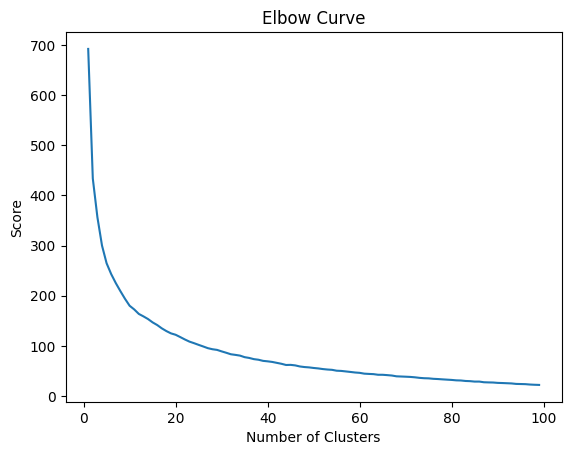

In [10]:
# Plot the elbow
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


In [11]:
K_value = 5
kmeans_model = KMeans(n_clusters=K_value, n_init='auto') 
kmeans_model.fit(d2v_model.dv.vectors)

__clusters = kmeans_model.predict(d2v_model.dv.vectors)
labels = kmeans_model.labels_.tolist()


## Silhouette score
The silhouette score is a metric provided by scikit-learn that measures the quality of clustering results based on the average distance between samples within clusters and the average distance between samples in different clusters. It takes into account both the cohesion (how close samples are to each other within the same cluster) and the separation (how far samples are from samples in other clusters). The range is from -1 to 1.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [12]:
silhouette_avg = silhouette_score(d2v_model.dv.vectors, labels)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.23722751


---
## PCA Analysis and Plotting
We use Principal Component Analysis (PCA) to flatten the 300-dimension document vectors onto a 2D shape for plotting. The banding in the graph below is an artefact of PCA, as the resulting components are not correlated.

In [13]:
__l = kmeans_model.predict(d2v_model.dv.vectors)
pca = PCA(n_components=2).fit(d2v_model.dv.vectors)
datapoint = pca.transform(d2v_model.dv.vectors)


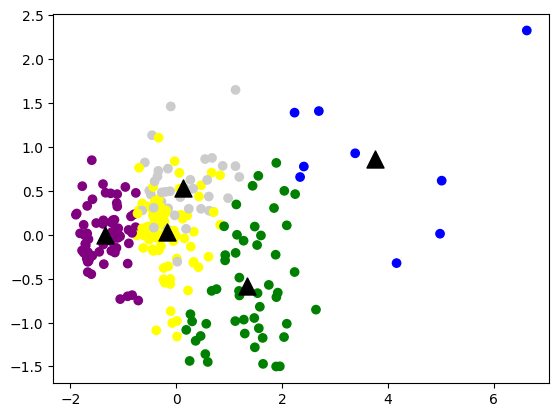

In [14]:
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#cccccc"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')

plt.show()


---
## Link to Municipality Data
This section three-way merges the clusters we found with the municipality data and document details for evaluation. Municipalities are indexed by their GM-code. Documents by their base file name.

In [15]:
CLUSTER='cluster'
MUNICIPALITY_ID='GM_Code'

kmeans_clusters = pd.DataFrame(index=corpus.index)
kmeans_clusters['DocID'] = corpus.index
kmeans_clusters[CLUSTER] = labels
kmeans_clusters[MUNICIPALITY_ID] = corpus.index.str.slice(0, 6)

kmeans_clusters.head()

,DocID,cluster,GM_Code
index,,,
GM0003DV02,GM0003DV02,4,GM0003
GM0005DV01,GM0005DV01,1,GM0005
GM0007DV01,GM0007DV01,1,GM0007
GM0009DV01,GM0009DV01,0,GM0009
GM0034DV01,GM0034DV01,0,GM0034


In [16]:
kmeans_clusters_with_municipalities = kmeans_clusters.merge(municipalities, how="left", on=MUNICIPALITY_ID).set_index('DocID')

# the merge adds suffixes to ensure unique column names, so we strip those off
# again since we have no name clashes.
kmeans_clusters_with_municipalities.columns=kmeans_clusters_with_municipalities.columns.str.rstrip('_x') 
kmeans_clusters_with_municipalities.head()


,cluster,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,Windenergie_2021,Zonneenergie_2021,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat
DocID,,,,,,,,,,,,,,,,,,,,
GM0003DV02,4,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
GM0005DV01,1,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,Veel,Veel,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder
GM0007DV01,1,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,Geen,Veel,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder
GM0009DV01,0,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,Beperkt,Veel,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder
GM0034DV01,0,GM0034,Almere,Flevoland,Groot,Modaal,sterk stedelijk,D66,Veel,Veel,Veel,Veel,Gemiddeld,Veel,Laag,Middel,Laag,Middel,meer,veel lager


In [17]:
kmeans_clusters_with_everything = kmeans_clusters_with_municipalities.join(documents)
kmeans_clusters_with_everything.head()


,cluster,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,...,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat,Titel,Jaar
DocID,,,,,,,,,,,,,,,,,,,,,
GM0003DV02,4,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,...,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0005DV01,1,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,...,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder,Milieubeleidsplan 2009-2012,2009
GM0007DV01,1,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,...,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder,Milieubeleidsprogramma 2007-2015,2007
GM0009DV01,0,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,...,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder,Duurzaamheidsvisie 2016-2018,2016
GM0034DV01,0,GM0034,Almere,Flevoland,Groot,Modaal,sterk stedelijk,D66,Veel,Veel,...,Gemiddeld,Veel,Laag,Middel,Laag,Middel,meer,veel lager,Plan van aanpak duurzaamheidsagenda,2010


In [18]:
kmeans_clusters_with_everything.to_parquet("../data/Governance/Doc2Vec_clusters.parquet")
kmeans_clusters_with_everything.loc[kmeans_clusters_with_everything[CLUSTER]==4, ['GM_Code', 'Gemeente', 'Titel', 'Jaar']]


,GM_Code,Gemeente,Titel,Jaar
DocID,,,,
GM0003DV02,GM0003,Appingedam,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0037DV02,GM0037,Stadskanaal,Nota Duurzame Energie en Energiebesparing Stad...,2010
GM0053DV01,GM0053,Winsum,klimaatbeleid 2015-2020,2015
GM0058DV01,GM0058,Dongeradeel,Dongeradeel hat enerzjy!,2012
GM0072DV01,GM0072,Harlingen,Harlingen duurzaam verder,2015
GM0098DV01,GM0098,Weststellingwerf,Klimaatbeleidsplan 2010-2020,2010
GM0109DV01,GM0109,Coevorden,Klimaatsbeleidplan gemeente Coevorden 2009 en ...,2009
GM0148DV03,GM0148,Dalfsen,Meerjarenprogramma Duurzaamheid 2014-2015,2014
GM0150DV02,GM0150,Deventer,www.deventer.nl Uitvoeringsagenda Duurzaamheid...,2011


---
## Word Clouds and Word Lists
With the clustered established, we can now make word clouds of each of them. Before we can work with word clouds, we have to merge the K-Means clusters with the original corpus. The word clouds need the text.

In [19]:
corpus_with_cluster = corpus.join(kmeans_clusters)
corpus_with_cluster.head()


,body,GM_CODE,Titel,Jaar,DocID,cluster,GM_Code
index,,,,,,,
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011,GM0003DV02,4,GM0003
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...,GM0005,Milieubeleidsplan 2009-2012,2009,GM0005DV01,1,GM0005
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...,GM0007,Milieubeleidsprogramma 2007-2015,2007,GM0007DV01,1,GM0007
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...,GM0009,Duurzaamheidsvisie 2016-2018,2016,GM0009DV01,0,GM0009
GM0034DV01,verseonnr dagmail december raad gemeente almer...,GM0034,Plan van aanpak duurzaamheidsagenda,2010,GM0034DV01,0,GM0034


In [20]:
documents_with_cluster = corpus_with_cluster.iloc[:, 2:]
documents_with_cluster


,Titel,Jaar,DocID,cluster,GM_Code
index,,,,,
GM0003DV02,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011,GM0003DV02,4,GM0003
GM0005DV01,Milieubeleidsplan 2009-2012,2009,GM0005DV01,1,GM0005
GM0007DV01,Milieubeleidsprogramma 2007-2015,2007,GM0007DV01,1,GM0007
GM0009DV01,Duurzaamheidsvisie 2016-2018,2016,GM0009DV01,0,GM0009
GM0034DV01,Plan van aanpak duurzaamheidsagenda,2010,GM0034DV01,0,GM0034
...,...,...,...,...,...
GM1945DV01,Duurzaamheidsprogramma - Gemeente Berg en Dal,2013,GM1945DV01,4,GM1945
GM1955DV01,Milieuprogramma 2014,2014,GM1955DV01,0,GM1955
GM1955DV02,Zonne-energie in het buitengebied,0,GM1955DV02,3,GM1955


In [21]:
MIN_DF=15
MAX_DF=0.85
SUBLINEAR_TF=True

def document_bodies_in_cluster(corpus, cluster):
    return corpus[corpus[CLUSTER]==cluster][DOCUMENT_BODY]

def nlargest_of(corpus, cluster, n):
    docs = document_bodies_in_cluster(corpus, cluster)

    if len(docs) < MIN_DF:
        print(f"only {len(docs)} documents in cluster {cluster}, setting `min_df` and `max_df` system defaults")
        vectorizer = TfidfVectorizer(sublinear_tf=SUBLINEAR_TF)
    else:
        vectorizer = TfidfVectorizer(min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)

    counts = vectorizer.fit_transform(docs)
    totals = counts.sum(0)
    return pd.DataFrame(totals.T, index=vectorizer.get_feature_names_out())[0].nlargest(n)

def print_cluster(corpus, cluster):
    print(nlargest_of(corpus, cluster, 20))

def cloud_of_cluster(corpus, cluster):
    cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(nlargest_of(corpus, cluster, 50))
    plt.axis('off')
    plt.imshow(cloud);


energiebesparing    2.745979
wij                 2.652978
programma           2.625935
visie               2.569317
mobiliteit          2.504728
stad                2.492332
communicatie        2.492268
elektrisch          2.461976
ondernemen          2.429619
vervoer             2.402582
samenleving         2.397033
hoofdstuk           2.370946
regio               2.354532
economie            2.343461
verlichting         2.337312
actie               2.319062
extern              2.303304
eur                 2.273644
bewoner             2.257381
toekomst            2.253530
Name: 0, dtype: float64


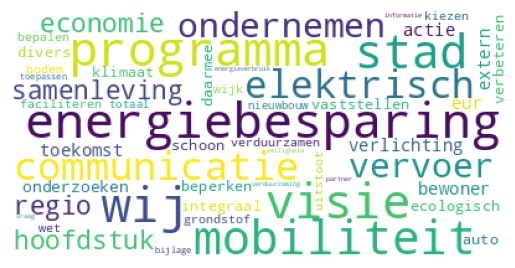

In [22]:
print_cluster(corpus_with_cluster, 0)
cloud_of_cluster(corpus_with_cluster, 0)


milieubeleidsplan    1.910009
bijlage              1.847154
milieubeleid         1.802961
eur                  1.746287
visie                1.727747
gevaarlijk           1.693831
milieubeheer         1.643564
mobiliteit           1.641330
nota                 1.630416
elektrisch           1.606664
instrument           1.558648
ecologisch           1.552481
vergunning           1.537368
ondernemer           1.531900
huishoudelijk        1.522501
wijk                 1.508880
inzameling           1.502782
wij                  1.497122
energieverbruik      1.492369
toezicht             1.478990
Name: 0, dtype: float64


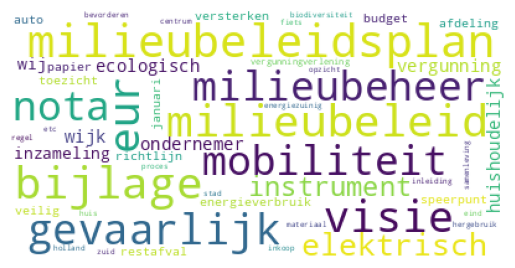

In [23]:
print_cluster(corpus_with_cluster, 1)
cloud_of_cluster(corpus_with_cluster, 1)


only 9 documents in cluster 2, setting `min_df` and `max_df` system defaults
gemeente      0.264894
duurzaam      0.246724
groen         0.237210
energie       0.234652
zullen        0.233562
goed          0.232114
maken         0.227978
per           0.220187
groot         0.219872
gebied        0.219665
komen         0.218309
jaar          0.218111
ander         0.217507
moeten        0.216164
stad          0.213299
gaan          0.211629
belangrijk    0.210363
mogelijk      0.209643
woning        0.207244
nieuw         0.205605
Name: 0, dtype: float64
only 9 documents in cluster 2, setting `min_df` and `max_df` system defaults


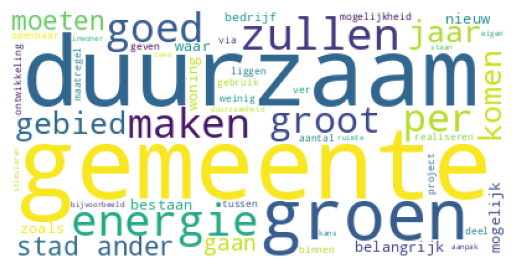

In [24]:
print_cluster(corpus_with_cluster, 2)
cloud_of_cluster(corpus_with_cluster, 2)


eur                 3.352645
energiebesparing    3.271861
gebouw              3.118151
inwoner             3.113965
thema               3.036112
wij                 3.034217
woning              2.992706
per                 2.922476
doelstelling        2.896611
burger              2.787045
groen               2.727616
milieu              2.725107
activiteit          2.682377
samenleving         2.652472
regionaal           2.650927
beleid              2.644756
maatschappelijk     2.623178
zien                2.620661
resultaat           2.607644
partij              2.603835
Name: 0, dtype: float64


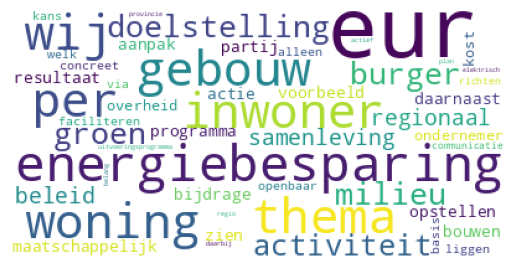

In [25]:
print_cluster(corpus_with_cluster, 3)
cloud_of_cluster(corpus_with_cluster, 3)


mobiliteit              1.818840
communicatie            1.783309
klimaatbeleid           1.779745
uitvoeringsprogramma    1.758229
uur                     1.742606
milieu                  1.738563
klimaat                 1.726506
energieverbruik         1.677083
warmte                  1.661640
bijlage                 1.650809
epc                     1.635944
concreet                1.614256
zonne                   1.569147
zonnepanel              1.555905
elektriciteit           1.544892
monitoring              1.543061
emissie                 1.525832
budget                  1.519226
inkop                   1.517889
energieneutraal         1.504564
Name: 0, dtype: float64


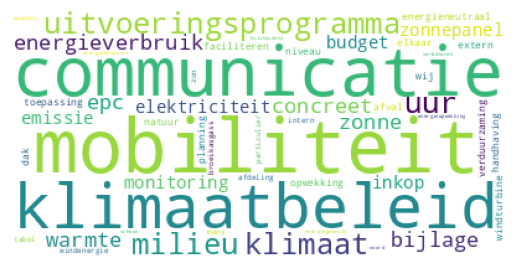

In [26]:
print_cluster(corpus_with_cluster, 4)
cloud_of_cluster(corpus_with_cluster, 4)


In [27]:
corpus_with_cluster[corpus_with_cluster[CLUSTER] == 3]


,body,GM_CODE,Titel,Jaar,DocID,cluster,GM_Code
index,,,,,,,
GM0047DV01,duurzaamheidsagenda slim werk slim bespaar voo...,GM0047,duurzaamheidsvisie vastgesteld,2016,GM0047DV01,3,GM0047
GM0050DV01,kwaliteit leefbaarheid realiseer samen duurzaa...,GM0050,Duurzaamheidsprogramma,0,GM0050DV01,3,GM0050
GM0060DV01,programma duurzaamheid waddeneilanden inleidin...,GM0060,Programma Duurzaamheid Waddeneilanden 2015,2014,GM0060DV01,3,GM0060
GM0148DV01,meerjarenprogramma klimaat duurzaamheid weg du...,GM0148,Meerjarenprogramma Duurzaamheid 2014-2015,2013,GM0148DV01,3,GM0148
GM0160DV01,duurzaam Hardenberg eeicuat laag soa ouurzoam ...,GM0160,Duurzaam Hardenberg Een bewuste keuze?,0,GM0160DV01,3,GM0160
...,...,...,...,...,...,...,...
GM1904DV01,stichtse vecht energiek samen sterk duurzaamhe...,GM1904,Duurzaamheidsvisie 2014-2020,2013,GM1904DV01,3,GM1904
GM1926DV01,pijnacker Nootdorp weg energieneutraal samenle...,GM1926,Pijnacker-Nootdorp op weg naar een energieneut...,2016,GM1926DV01,3,GM1926
GM1926DV02,pijnacker Nootdorp weg energieneutraal samenle...,GM1926,uitvoeringsprogramma duurzaamheid,2016,GM1926DV02,3,GM1926


In [28]:
corpus_with_cluster[CLUSTER].value_counts().sort_index()


cluster
0    77
1    51
2     9
3    70
4    38
Name: count, dtype: int64

Van de vijf clusters is er een cluster met slechts 5 documenten. Dit cluster bevat duidelijk andere documenten dan duurzaamheidsvisies en milieuprogramma's. De twee documenten uit Rijswijk (GM0603) betreffen groenbeleidsplannen. Het document van Kerkrade (GM0928) is een toekomstvisie en heeft samen met de energievisie van Voerendaal (GM0986) betrekking op de Parkstad regio in Zuid-Limburg en clusteren daarom mogelijk samen.

De andere clusters zijn op basis van de belangrijkste te woorden te benoemen als (volgorde kan wisselen met de run van het notebook):
- energiebeleid
- milieubeleidsplannen
- duurzaamheidsbeleid
- afvalbeleid

---
## Redo Wordclouds, but Minus All Documents

We now redo the word clouds, but instead of looking at the word clouds for the clusters, we try to remove a layer of common words by subtracting the IDF of all documents. We did this before, as part of the "_01 - TF-IDF on the Governance Set_" notebook.

Let's first generate the TF-IDF components for all documents. This code is near-verbatim from the "_01..._" notebook.


In [29]:
def tfidf_vectorize(series, min_df, max_df, sublinear_tf):
    if len(series) < MIN_DF:
        print(f"only {len(series)} documents in cluster, setting `min_df` and `max_df` system defaults")
        vectorizer = TfidfVectorizer(sublinear_tf=SUBLINEAR_TF)
    else:
        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, sublinear_tf=sublinear_tf)

    # run the vectorizer on the data
    word_matrix = vectorizer.fit_transform(series)
    words_list = vectorizer.get_feature_names_out()

    # take the output and package it into various useful data frames
    matrix = pd.DataFrame(index=series.index, columns=words_list, data=word_matrix.toarray())
    idf = pd.DataFrame(columns=words_list, data=[vectorizer.idf_])

    return matrix, idf


In [30]:
all_docs_matrix, _ = tfidf_vectorize(ALL_corpus[DOCUMENT_BODY], min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)

def cluster_vs_all_wordcloud(corpus_with_cluster, cluster, all_docs_matrix):
    cluster_docs_matrix, cluster_docs_idf = tfidf_vectorize(document_bodies_in_cluster(corpus_with_cluster, cluster), min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)
    
    unique_for_cluster = (cluster_docs_matrix.mean() - all_docs_matrix.mean()).dropna().sort_values()
    print(unique_for_cluster.nlargest(20))

    cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(unique_for_cluster)
    plt.axis('off')
    plt.imshow(cloud);


energiebesparing    0.026297
elektrisch          0.024509
mobiliteit          0.023473
ondernemen          0.022030
verduurzamen        0.021488
auto                0.021158
ecologisch          0.020876
planet              0.020714
biodiversiteit      0.020708
uitstoot            0.020662
energieverbruik     0.020625
cradle              0.020540
stad                0.020523
verduurzaming       0.020321
bodem               0.020307
grondstof           0.020217
verlichting         0.020188
klimaat             0.020076
energieneutraal     0.019992
actie               0.019867
dtype: float64


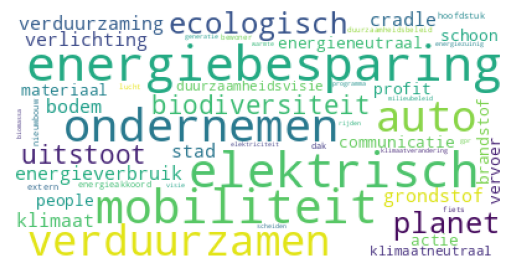

In [31]:
cluster_vs_all_wordcloud(corpus_with_cluster, 0, all_docs_matrix)


milieubeleidsplan    0.032679
milieubeleid         0.030570
gevaarlijk           0.028648
milieubeheer         0.025775
elektrisch           0.024038
bijlage              0.023732
bodemkwaliteit       0.023208
mobiliteit           0.023127
energieverbruik      0.023106
gpr                  0.022905
inzameling           0.022897
papier               0.022354
ecologisch           0.022285
biodiversiteit       0.022180
energiezuinig        0.022093
restafval            0.021890
vergunning           0.021724
huishoudelijk        0.021558
geluidhinder         0.021396
milieutak            0.021332
dtype: float64


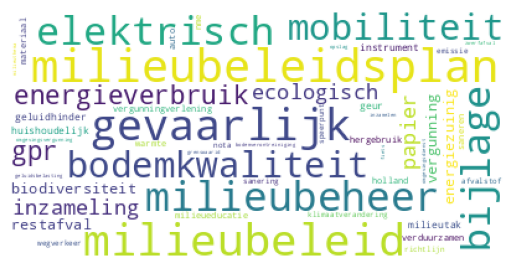

In [32]:
cluster_vs_all_wordcloud(corpus_with_cluster, 1, all_docs_matrix)


only 9 documents in cluster, setting `min_df` and `max_df` system defaults
rijswijk            0.018474
landgoederenzone    0.015772
circulair           0.014699
boomstructuur       0.013354
groenbeleidsplan    0.012902
prinses             0.012669
wijkpark            0.012499
beatrixlaan         0.012402
doelsoort           0.012013
bomenlaon           0.012012
stad                0.011855
zon                 0.011770
stakeholder         0.011741
droog               0.011546
zonne               0.011146
meter               0.010959
spoorlaan           0.010889
deelgebied          0.010867
energie             0.010860
warmte              0.010442
dtype: float64


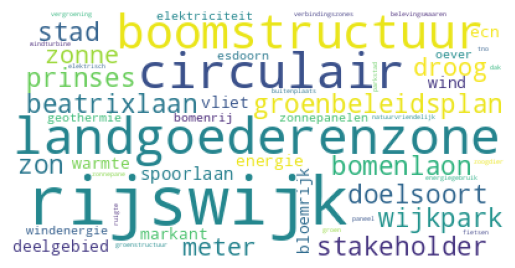

In [33]:
cluster_vs_all_wordcloud(corpus_with_cluster, 2, all_docs_matrix)


energiebesparing        0.037375
gebouw                  0.030564
thema                   0.030176
eur                     0.026681
actie                   0.026165
woning                  0.025966
elektrisch              0.025753
doelstelling            0.025499
voorbeeld               0.025226
energieneutraal         0.024996
milieu                  0.024660
uitvoeringsprogramma    0.024619
burger                  0.023634
klimaatbeleid           0.023533
mobiliteit              0.023203
faciliteren             0.023148
bouwen                  0.023019
inwoner                 0.023003
zonnepanel              0.022760
concreet                0.022741
dtype: float64


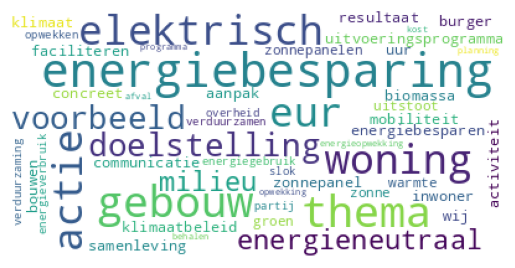

In [34]:
cluster_vs_all_wordcloud(corpus_with_cluster, 3, all_docs_matrix)


klimaatbeleid           0.041337
epc                     0.039405
mobiliteit              0.038809
warmte                  0.038567
energieverbruik         0.037977
klimaat                 0.037445
uitvoeringsprogramma    0.036386
emissie                 0.036365
elektriciteit           0.036255
uur                     0.036173
zonne                   0.035652
zonnepanel              0.035272
communicatie            0.034316
opwekking               0.033937
monitoring              0.033505
windturbine             0.033456
energieneutraal         0.033311
dak                     0.032504
broeikasgass            0.032438
windenergie             0.031736
dtype: float64


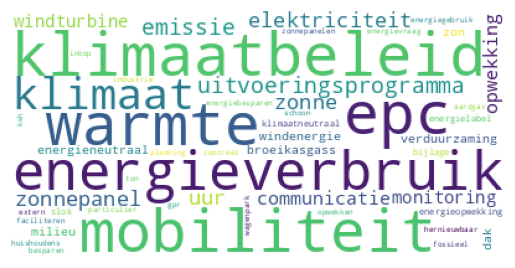

In [35]:
cluster_vs_all_wordcloud(corpus_with_cluster, 4, all_docs_matrix)
